### Library imports ###

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from scipy.sparse.csgraph import shortest_path
from scipy.optimize import minimize, curve_fit, LinearConstraint
from scipy.interpolate import PchipInterpolator
from openpyxl import load_workbook, Workbook
import os, time, math, random, itertools

### Main functions ###

#### Notch-Delta simulations ####

In [2]:
def simulate(M, t_final, dt, signalling_labels=None):
    if signalling_labels is not None:
        mask = np.zeros(M.shape[0], bool)
        mask[signalling_labels] = True
        M_eff = M.copy()
        M_eff[~mask, :] = 0
        M_eff[:, ~mask] = 0
    else:
        M_eff = M
        mask = np.ones(M.shape[0], bool)

    N = M.shape[0]
    y = np.random.rand(2*N) * 0.1
    steps = int(t_final / dt)
    for _ in range(steps):
        n, d = y[:N], y[N:]
        avg = M_eff.dot(d)
        dn = avg**k / (Ka**k + avg**k) - n
        dd = ν * (Kr**h / (Kr**h + n**h) - d)
        y[:N] += dt * dn
        y[N:] += dt * dd
        if signalling_labels is not None:
            y[N:][~mask] = 0

    delta = y[N:]
    if signalling_labels is not None:
        delta[~mask] = 0
    return delta

#### Signalling weights ####

In [3]:
def compute_omega_k(omega_func, wing_region, Lmax=None, method='simpson', num_simpson=101):
    
    gap = gap_dict[wing_region]
    n   = n_dict[wing_region]

    def omega_cut(z):
        z = np.asarray(z)
        vals = omega_func(z)
        if Lmax is not None:
            mask = (z >= 0) & (z <= Lmax)
            vals = np.where(mask, vals, 0.0)
        return vals

    if method == 'midpoint':
        mid_z = (np.arange(n) + 0.5) * gap
        return omega_cut(mid_z) * gap

    elif method == 'trapezoid':
        z_edges = np.linspace(0, n * gap, n + 1)
        y = omega_cut(z_edges)
        return (gap / 2) * (y[:-1] + y[1:])

    elif method == 'simpson':
        if num_simpson % 2 == 0:
            raise ValueError("num_simpson must be odd for Simpson's rule")
        omega_k = np.empty(n)
        for k in range(n):
            a, b = k * gap, (k + 1) * gap
            zs = np.linspace(a, b, num_simpson)
            ys = omega_cut(zs)
            h  = (b - a) / (num_simpson - 1)
            omega_k[k] = (h / 3) * (
                ys[0]
                + ys[-1]
                + 4 * ys[1:-1:2].sum()
                + 2 * ys[2:-1:2].sum()
            )
        return omega_k

    else:
        raise ValueError(f"Unknown method '{method}'")

#### Load centroid data ####

In [4]:
def load_centroids(wing_region):
    path = f"data/data_cell_geometry_{wing_region}.csv"
    df = pd.read_csv(path)

    # Find the maximum frame index
    max_frame = df["frame"].max()

    # Build a list of centroids, one entry per frame
    centroid_lists = []
    for frame in range(max_frame + 1):
        subdf = df[df["frame"] == frame]
        arr = subdf[["centroid_x", "centroid_y"]].to_numpy()
        centroid_lists.append(arr)

    return centroid_lists

#### SOP spacing plots ####

In [5]:
def fancy_plot(spacing_dict, Lmax_list, weight_type, wing_regions,
               saveQ=False, fig_size=(5,4), xlim=(0,25), ylim=(0.95, 2.35), smooth=0,
               degenplotQ=False, errorbarQ=False,
               title='sop_spacing', x_title='Depth (µm)',
               legend_loc='lower right'):

    plt.figure(figsize=fig_size)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    labels = [f"WD {i+1}" for i in range(len(wing_regions))]
    x = np.array(Lmax_list)

    for color, label, region in zip(colors, labels, wing_regions):
        data   = spacing_dict[region]
        y      = np.array([d for d, vr, flag in data])
        ystd   = np.array([vr for d, vr, flag in data])
        flags  = np.array([flag for d, vr, flag in data])

        # treat infinities as degenerate: replace with last finite and mark flag
        inf_idx = np.where(~np.isfinite(y))[0]
        if inf_idx.size:
            flags[inf_idx] = True
            for i in inf_idx:
                if i > 0:
                    y[i] = y[i-1]
                else:
                    y[i] = y[np.isfinite(y)][0]

        # error bars
        if errorbarQ:
            plt.errorbar(x, y, yerr=ystd, fmt='none',
                         ecolor=color, alpha=0.5, capsize=3)

        # main curve
        if smooth > 0 and len(x) > 1:
            xs    = np.linspace(x.min(), x.max(), 300)
            pchip = PchipInterpolator(x, y)
            ys    = pchip(xs)
            plt.plot(xs, ys, color=color, linewidth=3, label=label)
        else:
            plt.plot(x, y, color=color, linewidth=3, label=label)

        # degenerate segments
        if degenplotQ and flags.any():
            idxs = np.where(flags)[0]
            runs = np.split(idxs, np.where(np.diff(idxs) > 1)[0]+1)
            for run in runs:
                xr = x[run]; yr = y[run]
                if len(xr) > 1:
                    plt.plot(xr, yr, '-', color='white', linewidth=4, zorder=5)
                    plt.plot(xr, yr, '--', color='red',   linewidth=2, zorder=6)
                else:
                    plt.plot(xr, yr, 'o', color='white', markersize=8, zorder=5)
                    plt.plot(xr, yr, 'o', color='red',   markersize=5, zorder=6)

    plt.xlabel(x_title, fontsize=22)
    plt.ylabel('Mean SOP spacing', fontsize=22)
    plt.tick_params(labelsize=18)
    plt.xlim(xlim)
    plt.ylim(ylim); plt.grid(True, linestyle='--', alpha=0.6)

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if degenplotQ:
        deg_h = Line2D([0], [0], color='red', linestyle='--', linewidth=2)
        handles.append(deg_h); labels.append('Degen.')
    ax.legend(handles, labels, fontsize=12, frameon=True, loc=legend_loc) \
      .get_frame().set_edgecolor('black')
    ax.set_position([0.10, 0.15, 0.85, 0.75])

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if degenplotQ:
        deg_h = Line2D([0], [0], color='red', linestyle='--', linewidth=2)
        handles.append(deg_h); labels.append('Degen.')

    handles = [] # remove legend
    leg = ax.legend(
        handles, labels,
        fontsize=12,
        frameon=False,
        loc=legend_loc
    )
    # style legend box
    leg.get_frame().set_facecolor('white')
    leg.get_frame().set_alpha(0.8)
    # bring it to front
    leg.set_zorder(10)
    leg.get_frame().set_edgecolor('black')

    if saveQ:
        plt.savefig(f'figures/{title}_{weight_type}.pdf',
                    bbox_inches='tight', transparent=True)
    plt.show()

#### Graph plots ####

In [6]:
def plot_layer_graph(delta, centroids, A_layers, framenumber=0,
                     wing_region='',
                     sop_idx=None, adj0=None,
                     draw_rect=False, height=None, y_shift=0.0,
                     show_labels=True, figsize=(7,7),
                     node_size=300, label_font_size=8,
                     edge_color='black', edge_width=1.0,
                     show_other_layers=True,
                     other_edge_color='lightblue', other_edge_width=0.5,
                     saveQ=False):

    global full_dist

    pos = centroids[framenumber]
    adj = A_layers[framenumber]
    valid = np.nonzero(adj.sum(0) > 0)[0]

    fig, ax = plt.subplots(figsize=figsize)

    # draw union of all non‑focal layers, once per edge
    if show_other_layers:
        # build union adjacency
        union_adj = np.zeros_like(adj, dtype=bool)
        for k, m in enumerate(A_layers):
            if k == framenumber:
                continue
            union_adj |= (m > 0)

        # extract unique edges (i<j) in valid set
        r_u, c_u = np.nonzero(union_adj)
        mask_u   = (r_u < c_u) & np.isin(r_u, valid) & np.isin(c_u, valid)
        segs_u = [((pos[i,0], pos[i,1]), (pos[j,0], pos[j,1]))
                  for i, j in zip(r_u[mask_u], c_u[mask_u])]

        if segs_u:
            ax.add_collection(LineCollection(
                segs_u,
                colors=other_edge_color,
                linewidths=other_edge_width,
                zorder=0
            ))

    # draw focal layer edges, unique i<j
    r, c = np.nonzero(adj)
    mask_f = (r < c) & np.isin(r, valid) & np.isin(c, valid)
    segs_f = [((pos[i,0], pos[i,1]), (pos[j,0], pos[j,1]))
              for i, j in zip(r[mask_f], c[mask_f])]

    if segs_f:
        ax.add_collection(LineCollection(
            segs_f,
            colors=edge_color,
            linewidths=edge_width,
            zorder=1
        ))

    # nodes colored by delta
    pts = pos[valid]
    cols = np.zeros((len(valid), 3))
    cols[:, 0] = delta[valid]
    ax.scatter(
        pts[:, 0], pts[:, 1],
        c=cols, s=node_size,
        edgecolors='none', zorder=2
    )

    # labels
    if show_labels:
        for i in valid:
            ax.text(
                pos[i, 0], pos[i, 1], str(i),
                color='white', ha='center', va='center',
                fontsize=label_font_size, zorder=3
            )

    # optional rectangle + distance computation...
    if draw_rect:
        x, y = pos[:,0], pos[:,1]
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        y0 = y_min + y_shift * ((y_max - height) - y_min)

        rect = Rectangle(
            (x_min, y0),
            x_max - x_min, height,
            edgecolor='magenta', facecolor='none',
            linewidth=2, zorder=4
        )
        ax.add_patch(rect)

        graph = (adj0 > 0).astype(int)
        full_dist = shortest_path(csgraph=graph, directed=False, unweighted=True)
        d = band_min_sop_distance_at_shift(
            cents=np.array(centroids[0]),
            sop_idx=sop_idx,
            full_dist=full_dist,
            height=height,
            ys=y_shift
        )
        print(f"Mean SOP spacing at band shift={y_shift:.2f}: {d:.3f}")

    ax.set_aspect('equal')
    ax.axis('off')

    if saveQ:
        plt.savefig(
            f'figures/graph_plot_{wing_region}.pdf',
            dpi=300, bbox_inches='tight', transparent=False
        )
    plt.show()

#### SOP cell distance functions ####

In [7]:
def band_min_sop_distance_at_shift(cents, sop_idx, full_dist, height=50, ys=0.):

    global finite

    x = cents[:,0]
    y = cents[:,1]
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()

    # bottom of rectangle for this shift
    y0 = y_min + ys * ((y_max - height) - y_min)

    in_rect = np.where(
        (x >= x_min) & (x <= x_max) &
        (y >= y0)    & (y <= y0 + height)
    )[0]
    sops = [i for i in sop_idx if i in in_rect]
    if len(sops) < 2:
        return [np.nan, np.nan]

    dm = full_dist[np.ix_(sops, sops)]
    np.fill_diagonal(dm, np.inf)
    mins = np.min(dm, axis=1) - 1
    finite = mins[np.isfinite(mins)]
    
    return [finite.mean(), finite.std()] if finite.size else [np.nan, np.nan]

def band_avg_min_sop_distance(cents, sop_idx, adj0, height, y_shift_steps):

    global full_dist, d_list

    cents = np.asarray(cents)
    # build full‐graph distance matrix once
    graph = (adj0 > 0).astype(int)
    full_dist = shortest_path(csgraph=graph, directed=False, unweighted=True)

    # sample shifts
    d_list = []
    v_list = []
    for ys in np.linspace(0, 1, y_shift_steps):
        d, v = band_min_sop_distance_at_shift(
            cents, sop_idx, full_dist, height, ys
        )
        if not np.isnan(d):
            d_list.append(d)
            v_list.append(v)
            
    d_list = [x for x in d_list if x <= 6.5]

    return [float(np.mean(d_list)), float(np.mean(v_list))] if d_list else [np.inf, np.inf]

def compute_band_distance(wing_region,
                          weight_list=None,
                          omega_func=None,
                          t_final=100.0,
                          dt=0.1,
                          Lmax=None,
                          heights=[80, 110, 60],
                          y_shift_steps=20,
                          sim_number=1,
                          quad_method='simpson',
                          alpha=0.,
                          degen_T=1.0,
                          plotQ=False, normalQ=False, str_type='centroid',
                          **quad_kwargs):
    global delta, weight_list0, cents, adj0, sop_idx, sop_pairs, sop_pairs_mean, avg_results_v, sop_pairs_mean, avg_results, ds0
    # build weights
    if weight_list is None:
        if omega_func is None:
            raise ValueError("Either weight_list or omega_func must be provided")
        if normalQ: # option to normalise the weights
            weight_list_base = compute_omega_k(omega_func, wing_region, Lmax=Lmax, method=quad_method, **quad_kwargs)
            weight_list_all = compute_omega_k(omega_func, wing_region, Lmax=32, method=quad_method, **quad_kwargs)
            weight_list = np.array([i*sum(weight_list_base)/sum(weight_list_all) for i in weight_list_base])
        else:
            weight_list = compute_omega_k(omega_func, wing_region, Lmax=Lmax, method=quad_method, **quad_kwargs)
    weight_list0 = weight_list
    
    thresholds = [0.7, 0.75, 0.8, 0.85, 0.9] # creates a dictionary based on different Delta thresholds
    results = {th: [] for th in thresholds}
    results_v = {th: [] for th in thresholds} # variance
    
    #A_list  = A_dict[wing_region]
    if str_type == 'centroid':
        A_list = straight_adjacency(A_dict, centroids_dict, alpha)[wing_region]
    
    cents   = np.array(centroids_dict[wing_region][0])
    adj0    = A_dict[wing_region][0] # A_list[0]
    labels  = signalling_labels_dict[wing_region]
    heights_dict = {'wd_1': heights[0], 'wd_2': heights[1], 'wd_3': heights[2]}
    height=heights_dict[wing_region]
    sop_pairs = [] # for degenerate detection

    for sim in range(sim_number):
        wk    = weight_list
        if str_type == 'prune':
            straight_data = straight_prune(A_dict, centroids_dict, alpha)
            A_list, prune_idx = straight_data[0][wing_region], straight_data[1][wing_region]
            wk_new = [0 if i in prune_idx else val for i,val in enumerate(wk)]
            wk_new = [v * sum(wk) / sum(wk_new) for v in wk_new]
            wk = wk_new
            
        M     = sum(w*A for w,A in zip(wk, A_list))
        delta = simulate(M, t_final, dt, labels)
        for th in thresholds:
            sop_idx = np.where(delta>th)[0]
            d, v = band_avg_min_sop_distance(cents, sop_idx, adj0, height, y_shift_steps)
            results[th].append(d)
            results_v[th].append(v)

        # extra bits (plotting degenerate detection)
        if plotQ:
            plot_layer_graph(delta, centroids_dict[wing_region], A_dict[wing_region], wing_region=wing_region, framenumber=0)
        sop_pairs.append(np.triu(adj0[np.ix_(sop_idx, sop_idx)] > 0, k=1).sum())
    
    avg_results = {}
    for th, ds in results.items():
        finite = [x for x in ds if np.isfinite(x)]
        avg_results[th] = np.mean(finite) if finite else np.inf
        if th==0.8:
            ds0=ds
    avg_results_v = {}
    for th, ds in results_v.items():
        finite = [x for x in ds if np.isfinite(x)]
        avg_results_v[th] = np.mean(finite) if finite else np.inf

    # extra
    sop_pairs_mean = np.mean(sop_pairs)
    degenQ = sop_pairs_mean > degen_T or (sum(np.isinf(x) and x > 0 for x in ds0) / len(ds0)) > 0.5

    return avg_results, avg_results_v, degenQ

#### Straightening model ####

In [8]:
def straight_adjacency(A_dict, centroids_dict, alpha):
    
    straight = {}
    for region, layers in A_dict.items():
        A0 = layers[0].astype(float)
        if alpha >= 1.0:
            # α=1: every layer becomes exactly the apical adjacency
            straight[region] = [A0.copy() for _ in layers]
            continue

        pos0 = np.asarray(centroids_dict[region][0])
        new_layers = [A0.copy()]

        for k in range(1, len(layers)):
            Ak   = layers[k].astype(float)
            posk = np.asarray(centroids_dict[region][k])
            disp = np.linalg.norm(posk - pos0, axis=1)

            bin0 = A0 > 0
            bink = Ak > 0

            # extraneous edges and their displacements
            ex_i, ex_j = np.where(bink & ~bin0)
            disp_ex    = [max(disp[i],disp[j]) for i,j in zip(ex_i,ex_j) if i<j]
            # missing apical edges and their displacements
            mi_i, mi_j = np.where(bin0 & ~bink)
            disp_mi    = [max(disp[i],disp[j]) for i,j in zip(mi_i,mi_j) if i<j]

            # thresholds
            tau_rm  = np.quantile(disp_ex, 1 - alpha) if disp_ex else np.inf
            tau_add = np.quantile(disp_mi, alpha)     if disp_mi else -np.inf

            Anew = Ak.copy()
            # remove any non‐apical that are 'too displaced'
            for i,j in zip(ex_i, ex_j):
                if i<j and max(disp[i],disp[j]) >= tau_rm:
                    Anew[i,j] = Anew[j,i] = 0.0
            # add back any apical‐only that are 'close enough'
            for i,j in zip(mi_i, mi_j):
                if i<j and max(disp[i],disp[j]) <= tau_add:
                    Anew[i,j] = Anew[j,i] = A0[i,j]

            new_layers.append(Anew)

        straight[region] = new_layers

    return straight

def plot_straightening_nonapical(A_str_dict, region, alphas, saveQ=False):

    global deg_nonap_list
    
    # Boolean apical adjacency
    A0 = A_str_dict[0.0][region][0] > 0
    # per‐cell apical degree
    deg_apical = A0.sum(axis=1)
    # only keep cells with at least one apical neighbour
    mask       = (deg_apical > 0)
    deg_apical = deg_apical[mask]
    # remove outliers > 12
    deg_apical = deg_apical[deg_apical <= 12]

    # build non‐apical degrees by union across all deeper layers
    deg_nonap_list = []
    for α in alphas:
        layers = A_str_dict[α][region]
        nonap = np.zeros_like(A0, dtype=bool)
        for Ak in layers[1:]:
            nonap |= (Ak > 0) & ~A0
        deg_nonap = nonap.sum(axis=1)[mask]
        # remove outliers > 12
        deg_nonap = deg_nonap[deg_nonap <= 12]
        deg_nonap_list.append(deg_nonap)

    # x positions: 0 for apical, then 1..len(alphas)
    xs = np.arange(len(alphas)+1)

    fig, ax = plt.subplots(figsize=(8,3), constrained_layout=False)

    # Apical box at x=0
    bp0 = ax.boxplot(
        [deg_apical], positions=[xs[0]], widths=0.6,
        patch_artist=True, manage_ticks=False
    )
    for box in bp0['boxes']:
        box.set(facecolor='#F06B68', edgecolor='black')
    for part in ('whiskers','caps','medians','fliers'):
        for line in bp0[part]:
            line.set(color='black', linewidth=1)

    # Non-apical at x=1..end
    bp1 = ax.boxplot(
        deg_nonap_list, positions=xs[1:], widths=0.6,
        patch_artist=True, manage_ticks=False
    )
    for box in bp1['boxes']:
        box.set(facecolor='#1f77b4', edgecolor='black', alpha=.7)
    for part in ('whiskers','caps','medians','fliers'):
        for line in bp1[part]:
            line.set(color='black', linewidth=1)

    # xticks & labels
    labels = ['apical'] + [f"{int(100*α)}" for α in alphas]
    ax.set_xticks(xs)
    ax.set_xticklabels(labels, rotation=45)

    ax.set_xlabel('Straightening percentage (%)')
    ax.set_ylabel('Number of neighbours')
    ax.legend(
        [bp0["boxes"][0], bp1["boxes"][0]],
        ['Apical neighbours', 'Non-apical neighbours'],
        loc='upper right'
    )
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_position([0.10, 0.15, 0.85, 0.75])
    plt.title(f'WD {wd_dict[region]}')
    if saveQ:
        plt.savefig(f'figures/straight_neighbour_{region}.pdf', bbox_inches='tight', transparent=True)
    plt.show()

### Parameter setup and data loading ###

In [9]:
# Notch-Delta parameters
k, h = 2, 8
Ka, Kr = 0.1, 0.001
ν = 0.09
t_final = 100.0
dt = 0.1

# region‐specific parameters
wing_regions = ['wd_1', 'wd_2', 'wd_3']
wd_dict = {'wd_1': '1', 'wd_2': '2', 'wd_3': '3'}
gap_dict = {'wd_1': 0.5, 'wd_2': 0.3, 'wd_3': 0.5}
n_dict = {'wd_1': 50, 'wd_2':105, 'wd_3': 60}
signalling_labels_dict = {
    'wd_1': np.array([23,25,26,27,28,29,34,36,37,41,44,45,47,48,51,52,54,55,
                              56,57,58,60,63,64,65,67,68,69,71,73,74,76,79,80,82,
                              83,84,86,88,89,91,92,93,95,96,97,98,99,103,106,121,
                              124,125,130,139], dtype=int),
    'wd_2': np.array([5,8,12,13,14,16,17,18,19,20,21,22,28,29,30,33,34,37,
                              38,39,40,41,42,43,46,48,49,51,52], dtype=int),
    'wd_3': np.array([20,22,27,28,29,30,31,34,35,36,37,38,39,42,43,45,48,49,
                              51,52,53,54,55,56,57,58,59,60,62,64,65,66,67,68,69,
                              70,72,73,76,77,78,94,96,101], dtype=int)
}

# Notch intensity data
notch_data = np.array([
    78.882, 70.702, 62.452, 55.169, 49.589, 44.339, 40.863, 38.124,
    35.518, 33.322, 31.955, 31.507, 30.938, 30.339, 29.484, 29.244,
    29.084, 28.970, 28.560, 28.366, 28.093, 28.167, 27.262, 26.740,
    26.212, 26.267, 27.035, 26.509, 26.545, 25.619, 26.036, 26.059,
    25.479, 25.472, 25.191, 25.506, 24.864, 24.734, 24.919, 25.314,
    26.016, 25.677, 25.618, 25.282, 25.482, 25.690, 25.258, 25.165,
    25.084, 25.022, 25.243, 25.178, 25.359, 25.294, 25.470, 25.763,
    25.659, 25.891, 25.820, 25.924, 26.172, 26.732, 26.190, 26.571
])

# data loading
wing_regions = ['wd_1', 'wd_2', 'wd_3']
path_dict = {
    r: f'data/adjacency_matrices_{r}.xlsx'
    for r in wing_regions
}
sheets_dict = {
    r: pd.read_excel(path_dict[r], sheet_name=None, header=None)
    for r in wing_regions
}
A_dict = {
    r: [sheet.values.astype(float) for sheet in sheets_dict[r].values()]
    for r in wing_regions
}
centroids_dict = {
    r: load_centroids(r)
    for r in wing_regions
}

# signalling labels that touch apically
signalling_labels_apical_dict = {
    region: [i for i in labels if A_dict[region][0][i].sum() > 0]
    for region, labels in signalling_labels_dict.items()
}

# apical and non-apical neighbours
apical_neighbours_dict = {
    region: {
        i: [j for j in labels if A_dict[region][0][i, j] > 0]
        for i in labels
    }
    for region, labels in signalling_labels_dict.items()
}
nonapical_neighbours_dict = {
    region: {
        i: [j for j in labels if A_dict[region][0][i, j] == 0]
        for i in labels
    }
    for region, labels in signalling_labels_dict.items()
}

# create figures folder
os.makedirs('figures', exist_ok=True)


### Data fitting ###

#### Distance heights ####

In [10]:
def compute_avg_count(cents, h1, n_shifts=20):
    global counts
    y = cents[:, 1]
    y_min, y_max = y.min(), y.max()
    counts = []
    for s in np.linspace(0, 1, n_shifts):
        y0 = y_min + s * ((y_max - h1) - y_min)
        inside = (y >= y0) & (y <= y0 + h1)
        counts.append(inside.sum())
    return np.mean(counts)

regions = ['wd_1', 'wd_2','wd_3']
height_list = [85, 170, 105]
apical_cents = {
    region: np.array(centroids_dict[region][0])[signalling_labels_apical_dict[region]]
    for region in regions
}

count = []
for region, h1 in zip(regions, height_list):
    cents = apical_cents[region]
    count.append(compute_avg_count(cents, h1))
    
print(f"Counts for heights {height_list} → {count}")

Counts for heights [85, 170, 105] → [13.5, 13.5, 13.5]


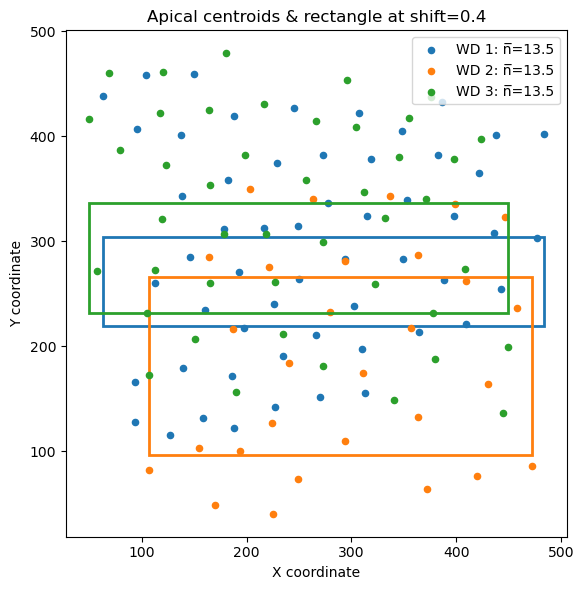

In [11]:
# inputs
regions     = ['wd_1', 'wd_2', 'wd_3']
height_list = [85, 170, 105]    # your three chosen heights
s_shift     = 0.4             # your desired shift in [0,1]
apical_cents = {
    region: np.array(centroids_dict[region][0])[signalling_labels_apical_dict[region]]
    for region in regions
}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(8,6))
ax = plt.gca()

for color, region, h1 in zip(colors, regions, height_list):
    cents = apical_cents[region]
    x, y = cents[:,0], cents[:,1]

    # compute average count over shifts
    avg_n = compute_avg_count(cents, h1, n_shifts=20)

    y_min, y_max = y.min(), y.max()
    y0 = y_min + s_shift * ((y_max - h1) - y_min)

    # draw rectangle
    rect = plt.Rectangle(
        (x.min(), y0),
        x.ptp(), h1,
        edgecolor=color, facecolor='none', linewidth=2
    )
    ax.add_patch(rect)

    # plot centroids
    ax.scatter(
        x, y,
        color=color, s=20,
        label=f"WD {wd_dict[region]}: n̅={avg_n:.1f}"
    )

ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title(f'Apical centroids & rectangle at shift={s_shift}')
ax.legend()
ax.set_aspect('equal','box')
plt.tight_layout()
if False:
    plt.savefig(f'figures/heights_spacing.pdf', bbox_inches='tight', transparent=True)
plt.show()


#### Notch intensity data ####

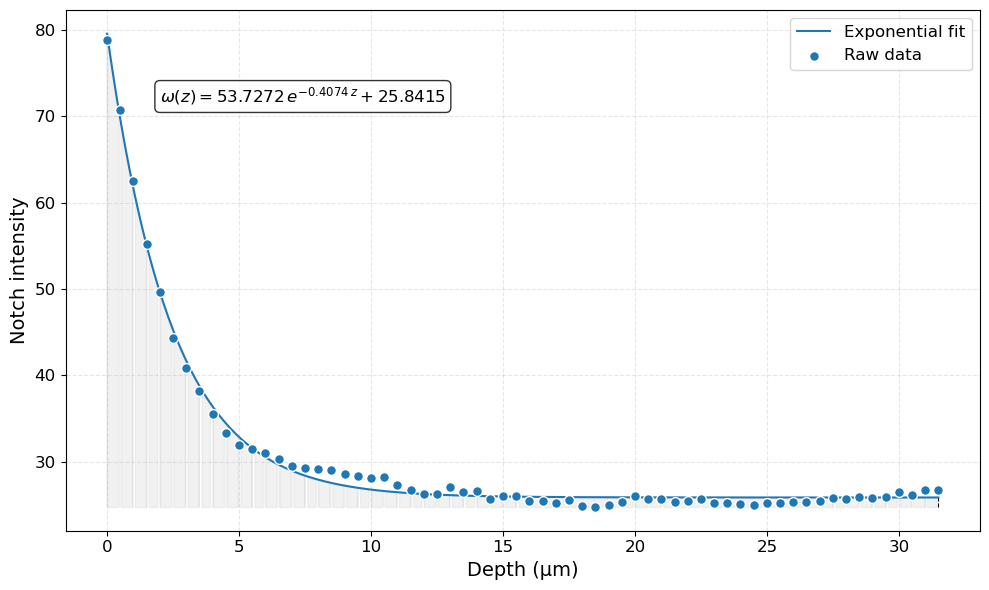

In [12]:
# raw notch data as a horizontal array
notch_data = np.array([
    78.882, 70.702, 62.452, 55.169, 49.589, 44.339, 40.863, 38.124,
    35.518, 33.322, 31.955, 31.507, 30.938, 30.339, 29.484, 29.244,
    29.084, 28.970, 28.560, 28.366, 28.093, 28.167, 27.262, 26.740,
    26.212, 26.267, 27.035, 26.509, 26.545, 25.619, 26.036, 26.059,
    25.479, 25.472, 25.191, 25.506, 24.864, 24.734, 24.919, 25.314,
    26.016, 25.677, 25.618, 25.282, 25.482, 25.690, 25.258, 25.165,
    25.084, 25.022, 25.243, 25.178, 25.359, 25.294, 25.470, 25.763,
    25.659, 25.891, 25.820, 25.924, 26.425, 26.172, 26.732, 26.719
])

# z‐coordinates: 0, 0.5, 1.0, ... µm
z = np.arange(len(notch_data)) * 0.5

# model: ω(z) = A * exp(-B z) + C
def omega_exp(z, A, B, C):
    return A * np.exp(-B * z) + C

# initial parameter guesses
p0 = [notch_data[0] - notch_data[-1], 0.1, notch_data[-1]]

# perform the fit
popt, pcov = curve_fit(omega_exp, z, notch_data, p0=p0)
A_fit, B_fit, C_fit = popt

# plot the result with shaded bars + data + equation
nice_blue = "#1f77b4"
gap       = 0.5
max_depth = z.max()
n_bars    = int(max_depth / gap)

plt.figure(figsize=(10, 6))

# exponential fit curve
zs       = np.linspace(0, max_depth, 300)
fit_vals = omega_exp(zs, A_fit, B_fit, C_fit)
plt.plot(zs,
         fit_vals,
         label="Exponential fit",
         color=nice_blue,
         zorder=2)

# shaded vertical slices
y_min = np.min(notch_data)
for i in range(n_bars):
    start = i * gap
    end   = (i + 1) * gap
    mask  = (zs >= start) & (zs < end)
    plt.fill_between(zs[mask],
                     fit_vals[mask],
                     y_min,
                     color="lightgray",
                     alpha=0.3,
                     zorder=1)
    # vertical line up to the curve
    idx = np.argmin(np.abs(zs - start))
    h   = fit_vals[idx]
    plt.plot([start, start],
             [y_min, h],
             color="black",
             linestyle="-",
             linewidth=0.1,
             alpha=0.5,
             zorder=1)

# final boundary line
idx_end = np.argmin(np.abs(zs - n_bars * gap))
h_end   = fit_vals[idx_end]
plt.plot([n_bars * gap, n_bars * gap],
         [y_min, h_end],
         color="black",
         linestyle="--",
         linewidth=0.8,
         zorder=1)

# raw data points on top
plt.scatter(z,
            notch_data,
            color=nice_blue,
            edgecolor="white",
            s=50,
            zorder=3,
            label="Raw data")

# equation textbox (no \displaystyle)
eqn = rf"$\omega(z) = {A_fit:.4f}\,e^{{-{B_fit:.4f}\,z}} + {C_fit:.4f}$"
props = dict(boxstyle="round", facecolor="white", alpha=0.8)
plt.text(2,
         0.9 * fit_vals.max(),
         eqn,
         fontsize=12,
         bbox=props)

# labels, legend, grid
plt.xlabel("Depth (µm)", fontsize=14)
plt.ylabel("Notch intensity", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper right", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


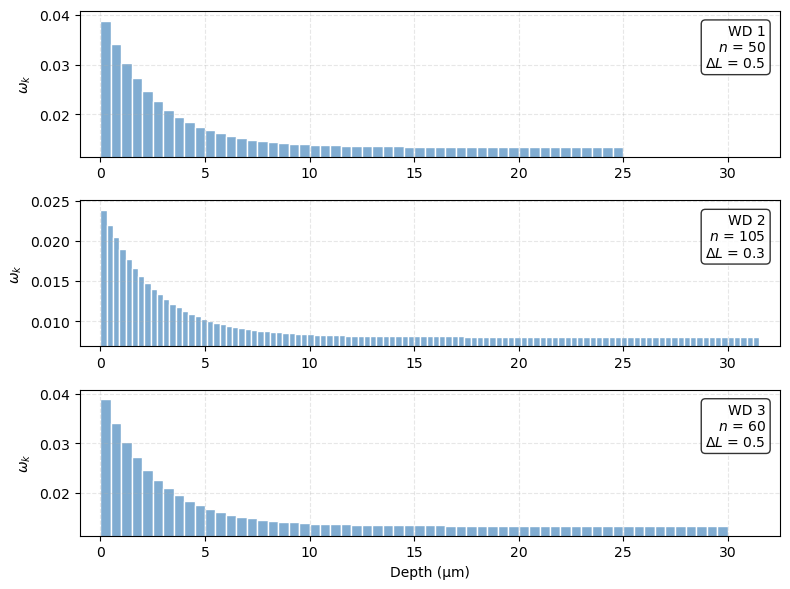

In [13]:
# signalling weight histograms

# define omega_func from fitted parameters
A0, B0, C0 = A_fit, B_fit, C_fit
I = A0 * (1 - np.exp(-B0 * 32)) / B0 + C0 * 32
A_new = A0 / I
C_new = C0 / I
B_new = B0
omega_func = lambda z: A_new * np.exp(-B_new * z) + C_new

# compute omega_k for each wing region
omega_k_dict = {}
for region in wing_regions:
    wk = compute_omega_k(
        omega_func,
        wing_region=region,
        Lmax=None,
        method='simpson',
        num_simpson=101
    )
    omega_k_dict[region] = wk

blueish = '#80ACD1'
regions = ['wd_1', 'wd_2', 'wd_3']

fig, axes = plt.subplots(len(regions), 1, figsize=(8, 6), sharex=False)

for ax, region in zip(axes, regions):
    wk  = omega_k_dict[region]
    gap = gap_dict[region]
    n   = len(wk)
    edges = np.arange(n) * gap  # left edge of each bar

    ax.bar(edges, wk,
           width=gap,
           align='edge',
           color=blueish,
           edgecolor='white')
    ax.set_xlim(-1, 32.5)
    ax.set_ylim(bottom=np.min(wk)*0.85)
    ax.set_ylabel(r'$\omega_k$')
    ax.grid(True, linestyle='--', alpha=0.3)

    # add info box in top-right (axes coords)
    info = f"WD {wd_dict[region]}\n" \
           f"$n$ = {n}\n" \
           r"$\Delta L$" f" = {gap}"
    props = dict(boxstyle="round", facecolor="white", alpha=0.8)
    ax.text(0.98, 0.91,
            info,
            transform=ax.transAxes,
            fontsize=10,
            ha="right",
            va="top",
            bbox=props)

axes[-1].set_xlabel('Depth (µm)')
plt.tight_layout()
if False:
    plt.savefig(f'weights_distribution.pdf', bbox_inches='tight', transparent=True)
plt.show()


### Custom plotting and visualization ###

#### Graph plots ####

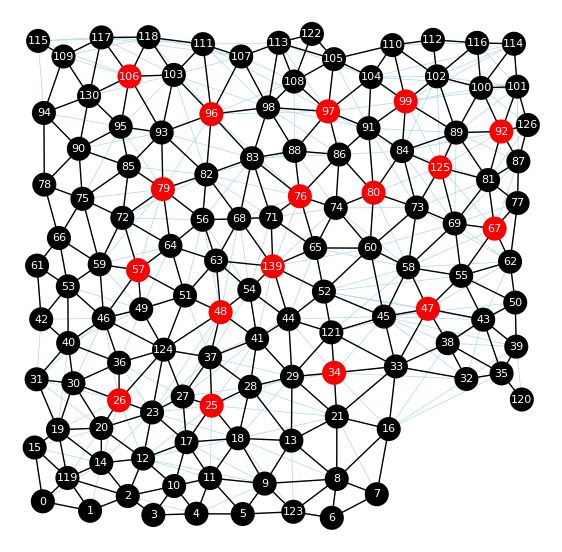

SOP spacing: 1.6352941176470586
Degenerate pattern: False


In [14]:
# example with weight function
wing_region = 'wd_1'

# uniform signalling
def omega_uniform(z):
    return 36

# linear signalling
def omega_lin(z):
    return -1.14 * z + 36
    
# exponential signalling
def omega_exp(z):
    return 40 * np.exp(-0.4 * z)

Lmax = 0.5 # sets the signalling depth in μm (w_k=0 for k*\Delta L > Lmax)
height_list = [85., 170., 105.] # band heights

for Lmax in [Lmax]:
    result = compute_band_distance(
        wing_region,
        omega_func=omega_exp,
        Lmax=Lmax,
        sim_number=1,
        quad_method='simpson',
        heights=height_list,
        plotQ=True,
        normalQ=False,
        alpha=0,
        degen_T=1.,
        y_shift_steps=20
    )

    print(f"SOP spacing: {result[0][0.8]}\nDegenerate pattern: {result[2]}")

#### SOP cell spacing plots ####

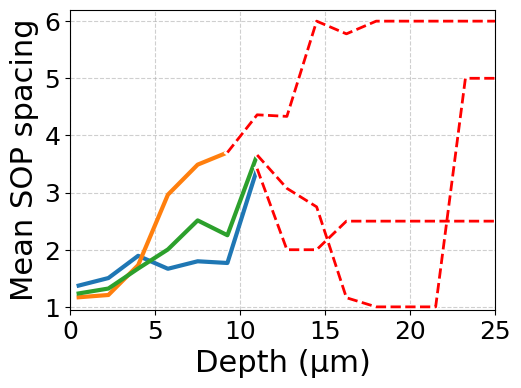

In [15]:
# uniform signalling
def omega_uniform(z):
    return 36.0

wing_regions = ['wd_1', 'wd_2', 'wd_3']
sim_number = 20
threshold = 0.8
Lmax_list = np.linspace(0.5, 25, 15)
height_list = [85., 170., 105.]
degen_T = 1.
normalQ = False

spacing_dict_uniform = {region: [] for region in wing_regions}
it=0
for Lmax in Lmax_list:
    for region in wing_regions:
        d, vr, degenQ = compute_band_distance(
            region,
            omega_func=omega_uniform,
            Lmax=Lmax,
            sim_number=sim_number,
            quad_method='midpoint',
            heights=height_list,
            degen_T=degen_T, normalQ=normalQ,
            y_shift_steps=20
        )
        d = d[threshold]
        vr = vr[threshold]
        spacing_dict_uniform[region].append([d,vr,degenQ])
        it=it+1
        print(f'{it}/{len(Lmax_list)*3}',end='\r')

fancy_plot(spacing_dict_uniform, Lmax_list, 'uniform', wing_regions, degenplotQ=True, ylim=(0.95,6.2), errorbarQ=False, saveQ=False)

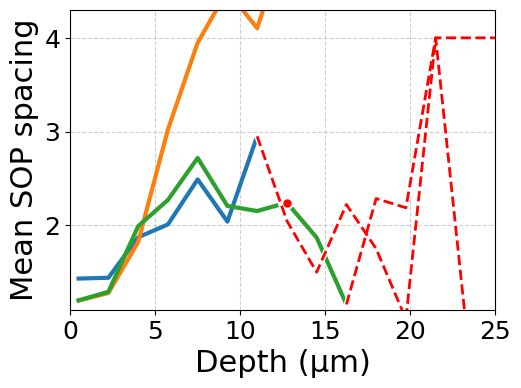

In [16]:
# linear signalling
def omega_lin(z):
    return -1.14 * z + 36

wing_regions = ['wd_1', 'wd_2', 'wd_3']
sim_number = 20
threshold = 0.8
Lmax_list = np.linspace(0.5, 25, 15)
height_list = [85., 170., 105.]
degen_T = 1.
normalQ = False

spacing_dict_lin = {region: [] for region in wing_regions}
it=0
for Lmax in Lmax_list:
    for region in wing_regions:
        d, vr, degenQ = compute_band_distance(
            region,
            omega_func=omega_lin,
            Lmax=Lmax,
            sim_number=sim_number,
            quad_method='trapezoid',
            heights=height_list,
            degen_T=degen_T, normalQ=normalQ,
            y_shift_steps=20
        )
        d = d[threshold]
        vr = vr[threshold]
        spacing_dict_lin[region].append([d,vr,degenQ])
        it=it+1
        print(f'{it}/{len(Lmax_list)*3}',end='\r')

fancy_plot(spacing_dict_lin, Lmax_list, 'lin', wing_regions, degenplotQ=True, ylim=(1.1,4.3), errorbarQ=False, saveQ=False)


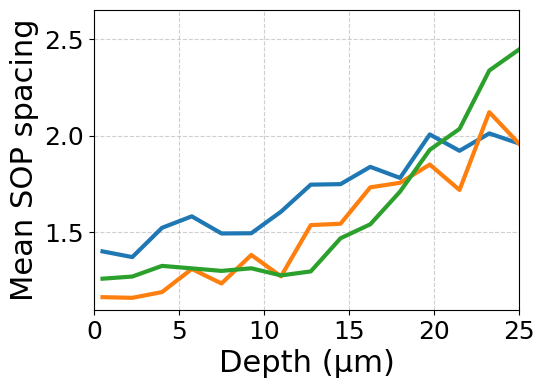

In [17]:
# exponential signalling
def omega_exp(z):
    return 10 * np.exp(-0.2 * z) + 2

wing_regions = ['wd_1', 'wd_2', 'wd_3']
sim_number = 20
threshold = 0.8
Lmax_list = np.linspace(0.5, 25, 15)
height_list = [85., 170., 105.]
degen_T = 1.
normalQ = False

spacing_dict_exp = {region: [] for region in wing_regions}
it=0
for Lmax in Lmax_list:
    for region in wing_regions:
        d, vr, degenQ = compute_band_distance(
            region,
            omega_func=omega_exp,
            Lmax=Lmax,
            sim_number=sim_number,
            quad_method='simpson',
            heights=height_list,
            degen_T=degen_T, normalQ=normalQ,
            y_shift_steps=20
        )
        d = d[threshold]
        vr = vr[threshold]
        spacing_dict_exp[region].append([d,vr,degenQ])
        it=it+1
        print(f'{it}/{len(Lmax_list)*3}',end='\r')

fancy_plot(spacing_dict_exp, Lmax_list, 'exp', wing_regions, degenplotQ=True, ylim=(1.1,2.65), errorbarQ=False, saveQ=False)

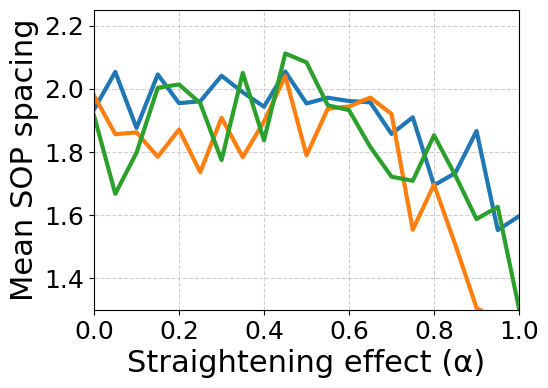

In [18]:
# exponential signalling (decay with straightening)
def omega_exp(z):
    return 40 * np.exp(-0.4 * z)

wing_regions = ['wd_1', 'wd_2', 'wd_3']
sim_number = 20
threshold = 0.8
alpha_list = np.linspace(0., 1., 21)
height_list = [85,170,105] #[125.0, 110.0, 135.0] # [130, 195, 155]#[125, 180, 155]
degen_T = 1.
normalQ = False

spacing_dict_exp_straight = {region: [] for region in wing_regions}
it=0
for alpha in alpha_list:
    for region in wing_regions:
        d, vr, degenQ = compute_band_distance(
            region,
            omega_func=omega_exp,
            Lmax=25,
            alpha=alpha,
            sim_number=sim_number,
            quad_method='simpson',
            heights=height_list,
            degen_T=degen_T, normalQ=normalQ,
            y_shift_steps=20,
            str_type='centroid'
        )
        d = d[threshold]
        vr = vr[threshold]
        spacing_dict_exp_straight[region].append([d,vr,degenQ])
        it=it+1
        print(f'{it}/{len(alpha_list)*3}',end='\r')

fancy_plot(spacing_dict_exp_straight, alpha_list, 'exp', wing_regions, degenplotQ=True, xlim=(0,1), ylim=(1.3,2.25), errorbarQ=False,
           title='sop_spacing_straight', x_title='Straightening effect (α)', legend_loc='lower left', saveQ=False)

#### Straightening plots ####

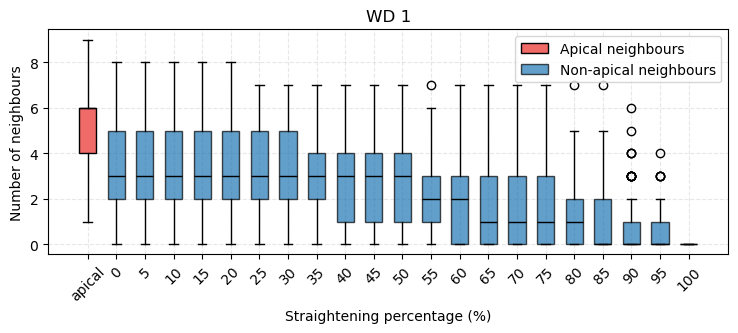

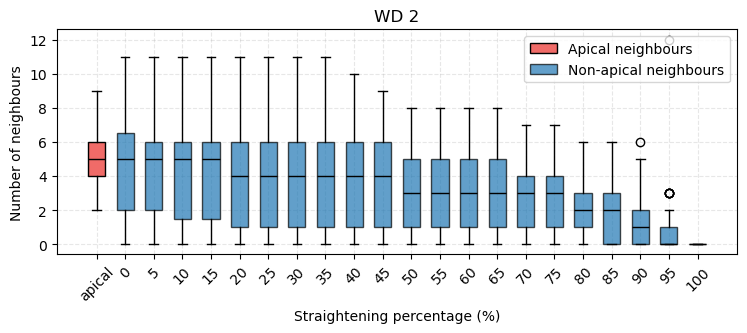

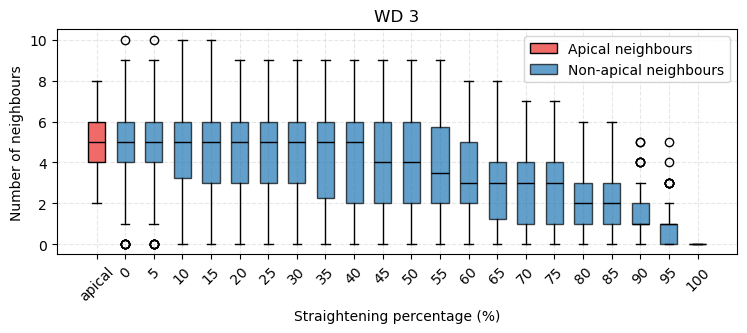

In [19]:
# number of neighbours vs straightening percentage
alphas = np.linspace(0,1,21)
A_str_dict = {
    α: straight_adjacency(A_dict, centroids_dict, α)
    for α in alphas
}
plot_straightening_nonapical(A_str_dict, 'wd_1', alphas, saveQ=False)
deg_wd_1 = deg_nonap_list
plot_straightening_nonapical(A_str_dict, 'wd_2', alphas, saveQ=False)
deg_wd_2 = deg_nonap_list
plot_straightening_nonapical(A_str_dict, 'wd_3', alphas, saveQ=False)
deg_wd_3 = deg_nonap_list


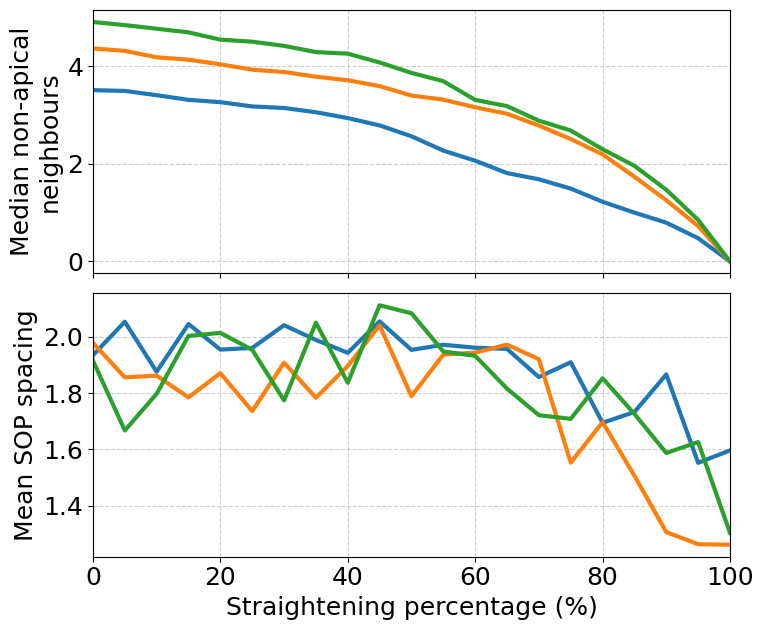

In [20]:
# comparison between mean neighbour change and SOP spacing

deg_mean_wd_1 = [np.mean(i) for i in deg_wd_1]
deg_mean_wd_2 = [np.mean(i) for i in deg_wd_2]
deg_mean_wd_3 = [np.mean(i) for i in deg_wd_3]
deg_mean = np.array([deg_mean_wd_1, deg_mean_wd_2, deg_mean_wd_3])

sop_mean_wd_1 = [i[0] for i in spacing_dict_exp_straight['wd_1']]
sop_mean_wd_2 = [i[0] for i in spacing_dict_exp_straight['wd_2']]
sop_mean_wd_3 = [i[0] for i in spacing_dict_exp_straight['wd_3']]
sop_mean = np.array([sop_mean_wd_1, sop_mean_wd_2, sop_mean_wd_3])

x = np.linspace(0, 100, 21)
colours = ['#1f77b4', '#ff7f0e', '#2ca02c']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Top plot: deg_mean
for i in range(3):
    ax1.plot(x, deg_mean[i], linewidth=3, color=colours[i])
ax1.set_ylabel('Median non-apical\nneighbours', fontsize=18)
ax1.tick_params(labelsize=18)
ax1.grid(True, linestyle='--', alpha=0.6)

# Bottom plot: sop_mean
for i in range(3):
    ax2.plot(x, sop_mean[i], linewidth=3, color=colours[i])
ax2.set_ylabel('Mean SOP spacing', fontsize=18)
ax2.set_xlabel('Straightening percentage (%)', fontsize=18)
ax2.tick_params(labelsize=18)
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0.10, 0.15, 0.85, 0.95])
plt.xlim(0, 100)
plt.savefig(f'figures/straight_neighbour_comparison.pdf', bbox_inches='tight', transparent=True)
plt.show()
